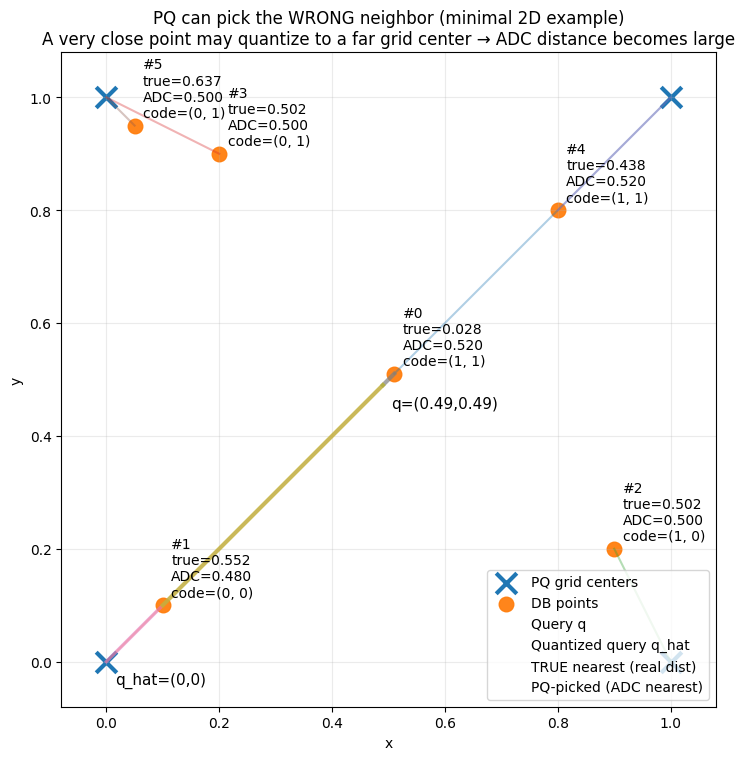

Query q = [0.49 0.49]   q_code = (0, 0)   q_hat = [0. 0.]
TRUE nearest: 0 point [0.51 0.51] true_dist 0.028284271247461926 ADC 0.5202 code (1, 1)
PQ-picked : 1 point [0.1 0.1] true_dist 0.5515432893255071 ADC 0.48019999999999996 code (0, 0)


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Minimal "PQ picks the wrong neighbor" demo (2D)
# - Clear markings:
#   * Database points
#   * PQ grid centers
#   * Query q
#   * Quantized query q_hat (ADC uses q to compute LUT, but this helps intuition)
#   * True nearest neighbor (by real Euclidean distance)
#   * PQ-picked neighbor (by PQ/ADC approximate distance)
#   * "Snap" lines: each DB point -> its quantized grid center
# ============================================================

# Query: intentionally near the boundary between 0 and 1 on both axes
q = np.array([0.49, 0.49])

# Two key database points:
A = np.array([0.51, 0.51])  # TRUE nearest (very close), but encodes to (1,1)
B = np.array([0.10, 0.10])  # Far, but encodes to (0,0) which is closer to q than (1,1)

# Add a few more points for context
pts = np.array([
    A,                 # #0
    B,                 # #1
    [0.90, 0.20],       # #2
    [0.20, 0.90],       # #3
    [0.80, 0.80],       # #4
    [0.05, 0.95],       # #5
], dtype=float)

# --- PQ-like 1D codebooks on each axis (2 centers per axis -> 2x2 grid) ---
cx = np.array([0.0, 1.0])  # x centers
cy = np.array([0.0, 1.0])  # y centers

def encode_pq(p):
    ix = int(np.argmin((p[0] - cx) ** 2))
    iy = int(np.argmin((p[1] - cy) ** 2))
    return ix, iy

# "Quantized query" just for intuition (ADC doesn't actually quantize q)
q_code = encode_pq(q)
q_hat = np.array([cx[q_code[0]], cy[q_code[1]]], dtype=float)

# ADC LUT for query
Dx = (q[0] - cx) ** 2
Dy = (q[1] - cy) ** 2

def adc_distance(code):
    ix, iy = code
    return float(Dx[ix] + Dy[iy])

true_d = np.linalg.norm(pts - q, axis=1)
codes = [encode_pq(p) for p in pts]
pq_d = np.array([adc_distance(c) for c in codes])

i_true = int(np.argmin(true_d))
i_pq = int(np.argmin(pq_d))

# Reconstructed (quantized) points: grid intersection for each DB point
recon = np.array([[cx[ix], cy[iy]] for (ix, iy) in codes], dtype=float)

# --- Plot ---
plt.figure(figsize=(8.5, 8.5))

# PQ grid centers (cartesian product)
grid = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
plt.scatter(grid[:,0], grid[:,1], marker='x', s=220, linewidths=3, label="PQ grid centers")

# Database points
plt.scatter(pts[:,0], pts[:,1], s=110, alpha=0.95, label="DB points")

# Snap lines: DB point -> its quantized center
for p, r in zip(pts, recon):
    plt.plot([p[0], r[0]], [p[1], r[1]], alpha=0.35)

# Query q
plt.scatter([q[0]], [q[1]], s=260, marker='o', facecolors='none', linewidths=3, label="Query q")

# Query quantized (for intuition)
plt.scatter([q_hat[0]], [q_hat[1]], s=260, marker='s', facecolors='none', linewidths=3, label="Quantized query q_hat")

# Line from q -> q_hat
plt.plot([q[0], q_hat[0]], [q[1], q_hat[1]], linewidth=2.5, alpha=0.6)

# True nearest neighbor highlight
plt.scatter([pts[i_true,0]], [pts[i_true,1]], s=420, facecolors='none', linewidths=4, label="TRUE nearest (real dist)")

# PQ-picked neighbor highlight (ADC)
plt.scatter([pts[i_pq,0]], [pts[i_pq,1]], s=420, facecolors='none', linewidths=4, label="PQ-picked (ADC nearest)")

# Connect q to the chosen neighbors
plt.plot([q[0], pts[i_true,0]], [q[1], pts[i_true,1]], linewidth=3, alpha=0.7)
plt.plot([q[0], pts[i_pq,0]],  [q[1], pts[i_pq,1]],  linewidth=3, alpha=0.7)

# Annotate everything
for i, p in enumerate(pts):
    plt.text(p[0]+0.015, p[1]+0.015,
             f"#{i}\ntrue={true_d[i]:.3f}\nADC={pq_d[i]:.3f}\ncode={codes[i]}",
             fontsize=10)

plt.text(q[0]+0.015, q[1]-0.04, f"q=({q[0]:.2f},{q[1]:.2f})", fontsize=11)
plt.text(q_hat[0]+0.015, q_hat[1]-0.04, f"q_hat=({q_hat[0]:.0f},{q_hat[1]:.0f})", fontsize=11)

plt.title("PQ can pick the WRONG neighbor (minimal 2D example)\n"
          "A very close point may quantize to a far grid center → ADC distance becomes large")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.08, 1.08)
plt.ylim(-0.08, 1.08)
plt.gca().set_aspect("equal", "box")
plt.grid(True, alpha=0.25)
plt.legend(loc="lower right")
plt.show()

print("Query q =", q, "  q_code =", q_code, "  q_hat =", q_hat)
print("TRUE nearest:", i_true, "point", pts[i_true], "true_dist", true_d[i_true], "ADC", pq_d[i_true], "code", codes[i_true])
print("PQ-picked :", i_pq,  "point", pts[i_pq],  "true_dist", true_d[i_pq],  "ADC", pq_d[i_pq],  "code", codes[i_pq])
